In [ ]:
#http://blog.yhat.com/posts/interactive-geospatial-analysis.html

In [14]:
import os
import pandas as pd
import numpy as np
from random import randint, uniform
from datetime import datetime
from urllib import urlretrieve
from zipfile import ZipFile

# geo stuff
import geopandas as gpd
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress stuff
from tqdm import tqdm_notebook, tqdm_pandas

# turn warnings off
import warnings
warnings.filterwarnings('ignore')


In [15]:
def get_nyc_shape_file(url, filename):

    # download file
    zipped = filename + '.zip'
    urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile', zipped)
    zipped = os.getcwd() + '/' + zipped

    # unzip file
    to_unzip = ZipFile(zipped, 'r')
    unzipped = os.getcwd() + '/' + filename + '_unzipped'
    to_unzip.extractall(unzipped)
    to_unzip.close()

    # get shape file
    for file in os.listdir(unzipped):
        if file.endswith(".shp"):
            shape_file =  unzipped + '/' + file

    # return full file path
    return shape_file


In [16]:
shape_file_url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
shape_file_dir = 'nyc_boroughs'
file_path = get_nyc_shape_file(shape_file_url,shape_file_dir)

In [17]:
gdf = gpd.GeoDataFrame.from_file(file_path)
gdf.head()

,boro_code,boro_name,geometry,shape_area,shape_leng
0,5.0,Staten Island,(POLYGON ((-74.05050806403247 40.5664220341608...,1.623820e+09,330470.010332
1,1.0,Manhattan,(POLYGON ((-74.01092841268031 40.6844914725429...,6.364715e+08,359299.095385
2,2.0,Bronx,(POLYGON ((-73.89680883223774 40.7958084451597...,1.186888e+09,464223.533367
3,3.0,Brooklyn,(POLYGON ((-73.86706149472118 40.5820879767934...,1.937476e+09,741074.466597
4,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.045024e+09,896310.510913


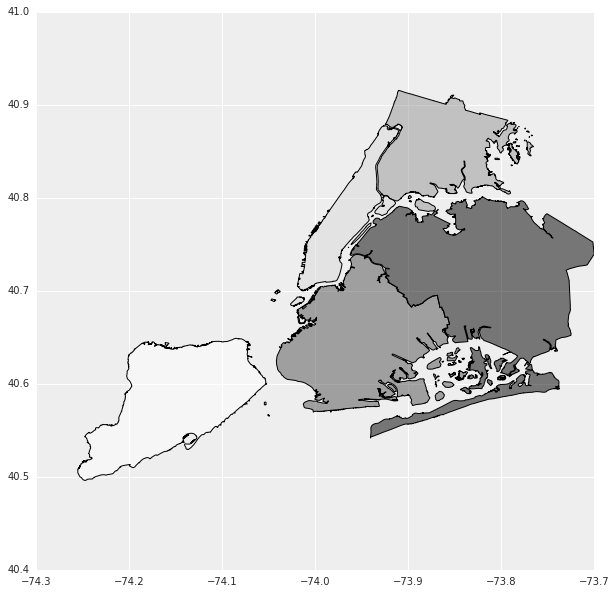

In [18]:
gdf.plot()

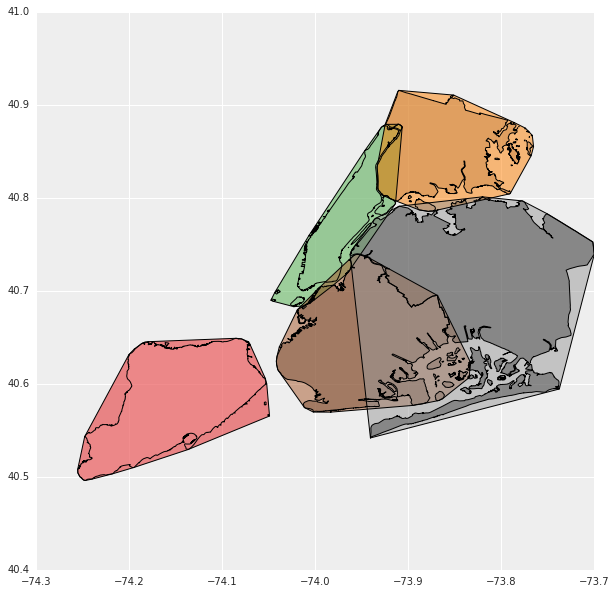

In [19]:
hulls = gdf['geometry'].convex_hull

# plot overlay
hulls.plot(ax=gdf.plot())

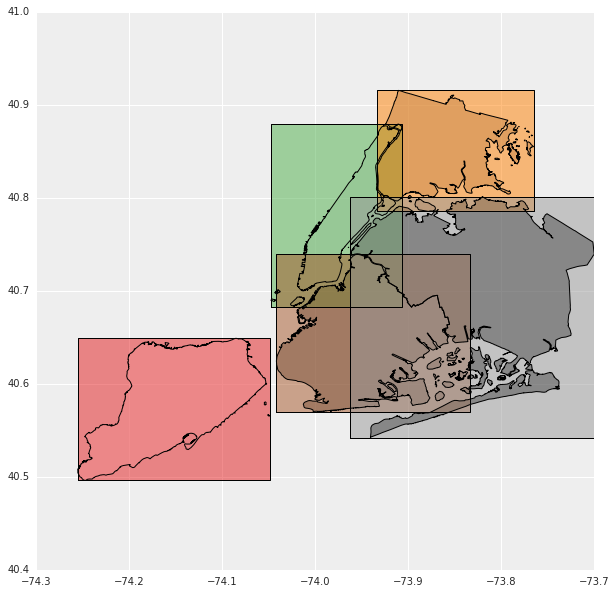

In [20]:
envelope = gpd.GeoSeries(hulls.envelope)

# plot overlay
envelope.plot(ax=gdf.plot())

In [21]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Traceback (most recent call last):
  File "/opt/conda/bin/jupyter-nbextension", line 6, in <module>
    sys.exit(notebook.nbextensions.main())
  File "/opt/conda/lib/python2.7/site-packages/jupyter_core/application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/opt/conda/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/opt/conda/lib/python2.7/site-packages/notebook/nbextensions.py", line 961, in start
    super(NBExtensionApp, self).start()
  File "/opt/conda/lib/python2.7/site-packages/jupyter_core/application.py", line 256, in start
    self.subapp.start()
  File "/opt/conda/lib/python2.7/site-packages/notebook/nbextensions.py", line 869, in start
    self.toggle_nbextension_python(self.extra_args[0])
  File "/opt/conda/lib/python2.7/site-packages/notebook/nbextensions.py", line 845, in toggle_nbextension_python
    logger=self.log)
  File "/opt/conda/

In [22]:
def sim_users(n, p, f):

    # create datetime range
    today = datetime.today().strftime("%m/%d/%Y")
    rng = pd.date_range(today, periods=p, freq=f)

    # get min/max coorindates
    min_x, min_y = gdf['geometry'].bounds.ix[:,:2].min()
    max_x, max_y = gdf['geometry'].bounds.ix[:,2:].max()

    # iterate over time datetime range and create user list
    sim_user_list = []
    for ts in tqdm_notebook(rng, desc='Progress', leave=True):
        for j in xrange(n):
            x = uniform(min_x, max_x)
            y = uniform(min_y, max_y)
            point = Point(x, y)
            gender = randint(0, 1)
            sim_user_list.append([ts, x, y, point, gender])

    # return dataframe
    sim_user_df = pd.DataFrame(sim_user_list, columns=['datetime', 'x', 'y', 'point', 'gender'])
    return sim_user_df

# simulate user data
sim_data = sim_users(100, 24, 'H')
sim_data.head()


,datetime,x,y,point,gender
0,2016-08-07,-74.218121,40.862249,POINT (-74.21812092906454 40.86224891034059),1
1,2016-08-07,-73.989963,40.840008,POINT (-73.98996331840108 40.84000750249559),1
2,2016-08-07,-74.122970,40.812577,POINT (-74.12296999390293 40.81257668446032),0
3,2016-08-07,-73.740853,40.847074,POINT (-73.74085327687318 40.84707422205093),0
4,2016-08-07,-74.018575,40.618078,POINT (-74.01857495791452 40.6180781213537),1


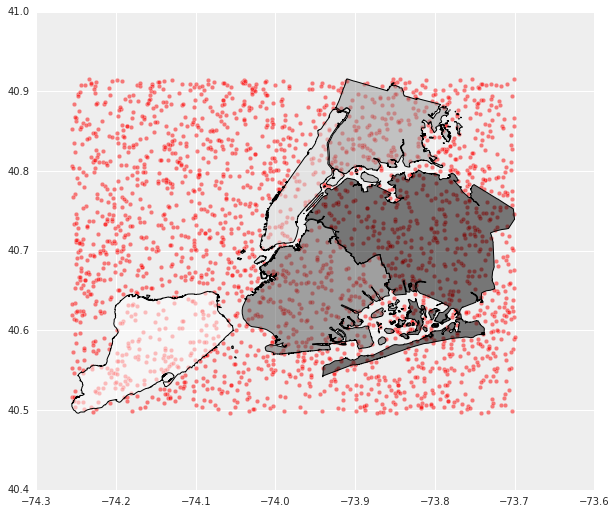

In [23]:
gdf.plot()
plt.scatter(x=sim_data['x'], y=sim_data['y'], alpha=0.5, c='r')

In [24]:
def make_plot(hour=1):

    # filter dataframe
    temp = sim_data[sim_data['contains_2']==True]
    temp=temp[temp['datetime'].dt.hour==hour]

    # plot
    hulls.plot(ax=gdf.plot())
    plt.scatter(x=temp['x'], y=temp['y'], s=30)

# create widget
interact(make_plot, hour=(1, 23, 1))

KeyError: 'contains_2'

<function __main__.make_plot>